<a href="https://colab.research.google.com/github/marianabetancur18/Clustering_Country-life-expectancy/blob/main/Clustering_Country_life_expectancy_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importación de librerias
*   pandas - Python Data Analysis: proporciona estructuras de datos y herramientas de análisis de datos de alto rendimiento y de fácil uso.
*   numpy: permite operar de forma optima y efectiva arreglos de N-dimensiones.
*   matplotlib: librería para graficar en 2D en python.
*   seaborn: librería para visualizar los datos basada en matplotlib, permite visualizar lso datos de muchas mas maneras y co mayores personalizaciones.
*   sklearn: proporciona elementos para algoritmos de machine learning en python como regresiones y clustering, diseñado para interoperar con Numpy y Scipy


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import linkage


%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (25, 12)
plt.style.use('ggplot')

## Reconocimiento inicial de los datos
Se importaran la base de datos a analizar, para este caso es la expectativa de vida por pais apartir del año 1990 al 2017.
El primer tratamiento se hara sobre el nombre del archivo, pues inicialmente su nombre contenia espacio en blanco, algo que no es considerado una buena practica. Por lo tanto se decidio cambiar el nombre del archivo a "Life.csv".Se llamara dataframe a la tabla con la lectura inicial de los datos.



In [ ]:
from google.colab import files
import io

uploaded = files.upload()
dataframe = pd.read_csv(io.BytesIO(uploaded["Life.csv"]), engine = 'python', header = 1, encoding= 'latin1')

dataframe.head()


Saving Life.csv to Life.csv


,HDI Rank (2017),Country,1990,Unnamed: 3,1991,Unnamed: 5,1992,Unnamed: 7,1993,Unnamed: 9,1994,Unnamed: 11,1995,Unnamed: 13,1996,Unnamed: 15,1997,Unnamed: 17,1998,Unnamed: 19,1999,Unnamed: 21,2000,Unnamed: 23,2001,Unnamed: 25,2002,Unnamed: 27,2003,Unnamed: 29,2004,Unnamed: 31,2005,Unnamed: 33,2006,Unnamed: 35,2007,Unnamed: 37,2008,Unnamed: 39,2009,Unnamed: 41,2010,Unnamed: 43,2011,Unnamed: 45,2012,Unnamed: 47,2013,Unnamed: 49,2014,Unnamed: 51,2015,Unnamed: 53,2016,Unnamed: 55,2017,Unnamed: 57
0,168,Afghanistan,49.9,..,50.6,..,51.3,..,52.0,..,52.5,..,53.1,..,53.5,..,54.0,..,54.5,..,55.0,..,55.5,..,56.0,..,56.6,..,57.3,..,57.9,..,58.5,..,59.1,..,59.7,..,60.2,..,60.8,..,61.2,..,61.7,..,62.1,..,62.5,..,62.9,..,63.3,..,63.7,..,64.0,..
1,68,Albania,71.8,..,71.8,..,71.8,..,71.9,..,72.0,..,72.2,..,72.5,..,72.8,..,73.2,..,73.6,..,74.0,..,74.3,..,74.6,..,74.8,..,75.0,..,75.2,..,75.4,..,75.7,..,75.9,..,76.3,..,76.7,..,77.0,..,77.4,..,77.7,..,78.0,..,78.2,..,78.3,..,78.5,..
2,85,Algeria,66.7,..,67.0,..,67.2,..,67.5,..,67.8,..,68.1,..,68.5,..,68.9,..,69.4,..,69.8,..,70.3,..,70.8,..,71.3,..,71.8,..,72.3,..,72.8,..,73.2,..,73.6,..,74.0,..,74.4,..,74.7,..,74.9,..,75.2,..,75.4,..,75.6,..,75.9,..,76.1,..,76.3,..
3,35,Andorra,76.5,..,76.7,..,76.9,..,77.0,..,77.2,..,77.4,..,77.6,..,77.9,..,78.2,..,78.5,..,78.9,..,79.2,..,79.5,..,79.8,..,80.0,..,80.2,..,80.3,..,80.5,..,80.6,..,80.7,..,80.8,..,80.9,..,81.1,..,81.2,..,81.3,..,81.4,a,81.5,a,81.7,a
4,147,Angola,41.7,..,41.9,..,42.1,..,42.3,..,42.7,..,43.1,..,43.7,..,44.4,..,45.2,..,46.1,..,47.1,..,48.2,..,49.3,..,50.5,..,51.7,..,52.8,..,54.0,..,55.1,..,56.2,..,57.2,..,58.2,..,59.0,..,59.8,..,60.4,..,60.9,..,61.2,..,61.5,..,61.8,..


## Continentes 
A continuacion se cargaran los continentes y su PIB de cada pais para un analisis mas adelante

In [ ]:
uploaded = files.upload()
dataframeContinentes = pd.read_csv(io.BytesIO(uploaded["Continentes.csv"]), engine = 'python', header=0, encoding= 'latin1')

dataframeContinentes = dataframeContinentes.rename(columns={'ï»¿Country': 'Country'})
dataframeContinentes.head()

Saving Continentes.csv to Continentes.csv


,Country,Continent,PIB
0,Afghanistan,Asia,19291.0
1,Albania,Europe,15279.0
2,Algeria,Africa,171091.0
3,Andorra,Europe,3154.0
4,Angola,Africa,88815.0


Se le asignara a cada pais su continente y su PBI realizando un join entre ambas *dataframes* para complementar la informacion presente en el data set

In [ ]:
dataframe = dataframe.join(dataframeContinentes.set_index('Country'), on='Country')
dataframe.head()

,HDI Rank (2017),Country,1990,Unnamed: 3,1991,Unnamed: 5,1992,Unnamed: 7,1993,Unnamed: 9,1994,Unnamed: 11,1995,Unnamed: 13,1996,Unnamed: 15,1997,Unnamed: 17,1998,Unnamed: 19,1999,Unnamed: 21,2000,Unnamed: 23,2001,Unnamed: 25,2002,Unnamed: 27,2003,Unnamed: 29,2004,Unnamed: 31,2005,Unnamed: 33,2006,Unnamed: 35,2007,Unnamed: 37,2008,Unnamed: 39,2009,Unnamed: 41,2010,Unnamed: 43,2011,Unnamed: 45,2012,Unnamed: 47,2013,Unnamed: 49,2014,Unnamed: 51,2015,Unnamed: 53,2016,Unnamed: 55,2017,Unnamed: 57,Continent,PIB
0,168,Afghanistan,49.9,..,50.6,..,51.3,..,52.0,..,52.5,..,53.1,..,53.5,..,54.0,..,54.5,..,55.0,..,55.5,..,56.0,..,56.6,..,57.3,..,57.9,..,58.5,..,59.1,..,59.7,..,60.2,..,60.8,..,61.2,..,61.7,..,62.1,..,62.5,..,62.9,..,63.3,..,63.7,..,64.0,..,Asia,19291.0
1,68,Albania,71.8,..,71.8,..,71.8,..,71.9,..,72.0,..,72.2,..,72.5,..,72.8,..,73.2,..,73.6,..,74.0,..,74.3,..,74.6,..,74.8,..,75.0,..,75.2,..,75.4,..,75.7,..,75.9,..,76.3,..,76.7,..,77.0,..,77.4,..,77.7,..,78.0,..,78.2,..,78.3,..,78.5,..,Europe,15279.0
2,85,Algeria,66.7,..,67.0,..,67.2,..,67.5,..,67.8,..,68.1,..,68.5,..,68.9,..,69.4,..,69.8,..,70.3,..,70.8,..,71.3,..,71.8,..,72.3,..,72.8,..,73.2,..,73.6,..,74.0,..,74.4,..,74.7,..,74.9,..,75.2,..,75.4,..,75.6,..,75.9,..,76.1,..,76.3,..,Africa,171091.0
3,35,Andorra,76.5,..,76.7,..,76.9,..,77.0,..,77.2,..,77.4,..,77.6,..,77.9,..,78.2,..,78.5,..,78.9,..,79.2,..,79.5,..,79.8,..,80.0,..,80.2,..,80.3,..,80.5,..,80.6,..,80.7,..,80.8,..,80.9,..,81.1,..,81.2,..,81.3,..,81.4,a,81.5,a,81.7,a,Europe,3154.0
4,147,Angola,41.7,..,41.9,..,42.1,..,42.3,..,42.7,..,43.1,..,43.7,..,44.4,..,45.2,..,46.1,..,47.1,..,48.2,..,49.3,..,50.5,..,51.7,..,52.8,..,54.0,..,55.1,..,56.2,..,57.2,..,58.2,..,59.0,..,59.8,..,60.4,..,60.9,..,61.2,..,61.5,..,61.8,..,Africa,88815.0


## Preprocesamiento

Se realiazaran una serie de pasos preliminares al analisis:

1. Se identificaron una serie de columnas vacias (NaN), se eliminaran pues no representan ninguna informacion acerca de los datos


In [ ]:
nombre_columnas=list(dataframe.columns)
columnas_vacias=[]
for contador in nombre_columnas:
     if contador.startswith("Un"):
       columnas_vacias.append(contador)
dataframe=dataframe.drop(columnas_vacias, axis=1)
dataframe

,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Continent,PIB
0,168,Afghanistan,49.9,50.6,51.3,52.0,52.5,53.1,53.5,54.0,54.5,55.0,55.5,56.0,56.6,57.3,57.9,58.5,59.1,59.7,60.2,60.8,61.2,61.7,62.1,62.5,62.9,63.3,63.7,64.0,Asia,19291.0
1,68,Albania,71.8,71.8,71.8,71.9,72.0,72.2,72.5,72.8,73.2,73.6,74.0,74.3,74.6,74.8,75.0,75.2,75.4,75.7,75.9,76.3,76.7,77.0,77.4,77.7,78.0,78.2,78.3,78.5,Europe,15279.0
2,85,Algeria,66.7,67.0,67.2,67.5,67.8,68.1,68.5,68.9,69.4,69.8,70.3,70.8,71.3,71.8,72.3,72.8,73.2,73.6,74.0,74.4,74.7,74.9,75.2,75.4,75.6,75.9,76.1,76.3,Africa,171091.0
3,35,Andorra,76.5,76.7,76.9,77.0,77.2,77.4,77.6,77.9,78.2,78.5,78.9,79.2,79.5,79.8,80.0,80.2,80.3,80.5,80.6,80.7,80.8,80.9,81.1,81.2,81.3,81.4,81.5,81.7,Europe,3154.0
4,147,Angola,41.7,41.9,42.1,42.3,42.7,43.1,43.7,44.4,45.2,46.1,47.1,48.2,49.3,50.5,51.7,52.8,54.0,55.1,56.2,57.2,58.2,59.0,59.8,60.4,60.9,61.2,61.5,61.8,Africa,88815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,n.a,Monaco,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,Europe,7188.0
193,n.a,Nauru,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,Oceania,118.0
194,n.a,San Marino,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,Europe,1655.0
195,a: Value from UNDESA (2011).,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN


Visualizando las 2 ultimas filas del dataframe solo tiene informacion acerca de la fecha de actualizacion y de donde se obtuvieron los datos, por tanto tambien se pueden eliminar.

In [ ]:
dataframe=dataframe.drop([196,195], axis=0)
dataframe


,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Continent,PIB
0,168,Afghanistan,49.9,50.6,51.3,52.0,52.5,53.1,53.5,54.0,54.5,55.0,55.5,56.0,56.6,57.3,57.9,58.5,59.1,59.7,60.2,60.8,61.2,61.7,62.1,62.5,62.9,63.3,63.7,64.0,Asia,19291.0
1,68,Albania,71.8,71.8,71.8,71.9,72.0,72.2,72.5,72.8,73.2,73.6,74.0,74.3,74.6,74.8,75.0,75.2,75.4,75.7,75.9,76.3,76.7,77.0,77.4,77.7,78.0,78.2,78.3,78.5,Europe,15279.0
2,85,Algeria,66.7,67.0,67.2,67.5,67.8,68.1,68.5,68.9,69.4,69.8,70.3,70.8,71.3,71.8,72.3,72.8,73.2,73.6,74.0,74.4,74.7,74.9,75.2,75.4,75.6,75.9,76.1,76.3,Africa,171091.0
3,35,Andorra,76.5,76.7,76.9,77.0,77.2,77.4,77.6,77.9,78.2,78.5,78.9,79.2,79.5,79.8,80.0,80.2,80.3,80.5,80.6,80.7,80.8,80.9,81.1,81.2,81.3,81.4,81.5,81.7,Europe,3154.0
4,147,Angola,41.7,41.9,42.1,42.3,42.7,43.1,43.7,44.4,45.2,46.1,47.1,48.2,49.3,50.5,51.7,52.8,54.0,55.1,56.2,57.2,58.2,59.0,59.8,60.4,60.9,61.2,61.5,61.8,Africa,88815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,144,Zambia,45.0,44.4,43.9,43.6,43.3,43.2,43.2,43.3,43.7,44.1,44.7,45.4,46.3,47.3,48.4,49.6,50.9,52.3,53.7,55.2,56.6,57.9,59.0,60.0,60.8,61.4,61.9,62.3,Africa,23309.0
191,156,Zimbabwe,57.9,56.7,55.3,53.9,52.3,50.8,49.3,48.0,46.7,45.6,44.8,44.3,44.1,44.2,44.6,45.3,46.3,47.7,49.3,51.1,53.0,54.8,56.5,58.1,59.4,60.4,61.2,61.7,Africa,21440.0
192,n.a,Monaco,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,Europe,7188.0
193,n.a,Nauru,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,..,Oceania,118.0


2. Una vez se hizo la limpieza inicial de los datos se procedera a observar que filas tienen datos faltantes, se ha observado ademas que los datos vacios en esta base de datos tienen la notacion ".."

In [ ]:
#Incialmente se miran si hay filas con datos vacios
#print (dataframe.isnull().sum())
#Se observa que como se creia inicialmente los datos vacios se llenan con alguna notacion
nombres_columnas=list(dataframe.columns)
for nombre in nombres_columnas:
  print(dataframe.loc[dataframe[nombre] == ".."])




Empty DataFrame
Columns: [HDI Rank (2017), Country, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, Continent, PIB]
Index: []
Empty DataFrame
Columns: [HDI Rank (2017), Country, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, Continent, PIB]
Index: []
    HDI Rank (2017)           Country 1990 1991  ... 2016  2017 Continent     PIB
109             106  Marshall Islands   ..   ..  ...   ..  73.6   Oceania   221.0
192             n.a            Monaco   ..   ..  ...   ..    ..    Europe  7188.0
193             n.a             Nauru   ..   ..  ...   ..    ..   Oceania   118.0
194             n.a        San Marino   ..   ..  ...   ..    ..    Europe  1655.0

[4 rows x 32 columns]
    HDI Rank (2017)           Country 1990 1991  ... 2016  2017 Continent  

Apartir de lo anterior se observa que para las categorias de 1990 a 2016 las filas 109, 192,193 y 194 poseen datos faltantes y para la categoria 2017 las filas 178,192,193,194.
Ademas las filas 178, 192,193 y 194 tienen un dato faltante en la categoria HDI Rank (2017).

Apartir de lo anteior, se debe tomar una decision acerca de esos datos faltantes, usaremos una hipotesis bastante usada en machine learning, si la fila tiene mas del 70-75% de los datos faltantes, ya que la muestra es lo sufiencientemente grande (195 datos) y al eliminar 4 datos(fila 194,193,192,109) se elimina unicamente el 2,05% de la informacion, se tomara esta decision para la filas que estan completamente vacias.

In [ ]:
dataframe=dataframe.drop([192,193,194], axis=0)
dataframe=dataframe.drop([109], axis=0)
dataframe

,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Continent,PIB
0,168,Afghanistan,49.9,50.6,51.3,52.0,52.5,53.1,53.5,54.0,54.5,55.0,55.5,56.0,56.6,57.3,57.9,58.5,59.1,59.7,60.2,60.8,61.2,61.7,62.1,62.5,62.9,63.3,63.7,64.0,Asia,19291.0
1,68,Albania,71.8,71.8,71.8,71.9,72.0,72.2,72.5,72.8,73.2,73.6,74.0,74.3,74.6,74.8,75.0,75.2,75.4,75.7,75.9,76.3,76.7,77.0,77.4,77.7,78.0,78.2,78.3,78.5,Europe,15279.0
2,85,Algeria,66.7,67.0,67.2,67.5,67.8,68.1,68.5,68.9,69.4,69.8,70.3,70.8,71.3,71.8,72.3,72.8,73.2,73.6,74.0,74.4,74.7,74.9,75.2,75.4,75.6,75.9,76.1,76.3,Africa,171091.0
3,35,Andorra,76.5,76.7,76.9,77.0,77.2,77.4,77.6,77.9,78.2,78.5,78.9,79.2,79.5,79.8,80.0,80.2,80.3,80.5,80.6,80.7,80.8,80.9,81.1,81.2,81.3,81.4,81.5,81.7,Europe,3154.0
4,147,Angola,41.7,41.9,42.1,42.3,42.7,43.1,43.7,44.4,45.2,46.1,47.1,48.2,49.3,50.5,51.7,52.8,54.0,55.1,56.2,57.2,58.2,59.0,59.8,60.4,60.9,61.2,61.5,61.8,Africa,88815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,78,Venezuela (Bolivarian Republic of),69.8,70.0,70.2,70.4,70.6,70.9,71.2,71.5,71.8,72.0,72.3,72.5,72.7,72.9,73.0,73.1,73.2,73.3,73.4,73.5,73.6,73.7,73.9,74.0,74.2,74.4,74.5,74.7,South America,482359.0
188,116,Viet Nam,70.5,70.8,71.1,71.4,71.7,72.0,72.2,72.5,72.8,73.0,73.3,73.5,73.7,73.9,74.1,74.3,74.4,74.6,74.8,74.9,75.1,75.3,75.5,75.7,75.9,76.1,76.3,76.5,Asia,261921.0
189,178,Yemen,57.9,58.2,58.5,58.8,59.0,59.3,59.5,59.7,59.9,60.2,60.4,60.6,60.9,61.2,61.5,61.9,62.2,62.6,62.9,63.2,63.5,63.8,64.0,64.3,64.5,64.7,65.0,65.2,Asia,22581.0
190,144,Zambia,45.0,44.4,43.9,43.6,43.3,43.2,43.2,43.3,43.7,44.1,44.7,45.4,46.3,47.3,48.4,49.6,50.9,52.3,53.7,55.2,56.6,57.9,59.0,60.0,60.8,61.4,61.9,62.3,Africa,23309.0


El dato 178 es un dato interesante por que solo le falta una entrada, en la categoria 2017, para esta fila antes de aplicar cualquier metodo estadistico, veremos como se comportan los datos.



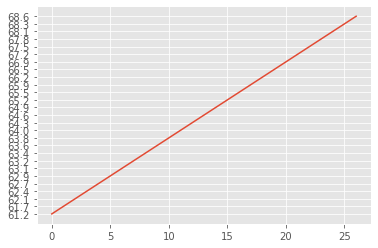

In [ ]:
Tuvalu=list(dataframe.loc[dataframe.loc[dataframe['Country'] == 'Tuvalu'].index[0]])
Tuvalu.remove("n.a")
Tuvalu.remove("Tuvalu")
Tuvalu.remove("..")
Tuvalu.remove('Oceania') #Continente
Tuvalu.remove(47.0) #PIB
plt.plot(Tuvalu)
dataframe.at[dataframe.loc[dataframe['Country'] == 'Tuvalu'].index[0],'2017']='1'

La expectativa de vida de tuvalu de 1990 a 2016 tiene un comportamiento lineal, por tanto estimaremos el valor faltante como si fuera parte de esa recta:


*   scipy.interpolate import lagrange retorna un polinomio interpolante de     lagrange



In [ ]:
from scipy.interpolate import lagrange
x=[0,27]
y=[float(Tuvalu[0]),float(Tuvalu[len(Tuvalu)-3])]
p=lagrange(x,y)
p(28)
i = dataframe[dataframe['Country'] == 'Tuvalu'].index[0]
dataframe.at[i,'2017']=str(round(p(28), 1))
dataframe.loc[dataframe['Country'] == 'Tuvalu'] 


,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Continent,PIB
178,n.a,Tuvalu,61.2,61.7,62.1,62.4,62.7,62.9,63.1,63.2,63.4,63.6,63.8,64.0,64.3,64.6,64.9,65.2,65.5,65.9,66.2,66.5,66.9,67.2,67.5,67.8,68.1,68.3,68.6,68.4,Oceania,47.0


## Reconocimiento de variables
Antes de comenzar a trabajar con un dataset hay que reconocer las variables que lo componen:


*   HDI Rank: variable categorica, nivel de medicion: ordinal
*   Country: variable categorica, nivel de medicion:  nominal
*   "1990"-"2017": variables continuas, nivel de medicion: de razon
* Continent: variable categorica con un nivel de medicion: nomimal
* PIB: variable continua con un nivel de medicion: de razon

Se sabe de estas variables country debe tener valores unicos para cada fila, a continuacion se verificara eso:

NOTA: Dadas las circunstancia que rodean a Corea del Norte [Korea (Democratic People's Republic of)] esta no reporta PIB.



In [ ]:
duplicate_country = dataframe['Country'].duplicated() #encontramos las filas donde country ya aparecio
dataframe[duplicate_country] #miramos si hay duplicados en el dataset

,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Continent,PIB


Se verificara que la variable HDI rank no tenga valores nulos en ninguna de sus filas:

In [ ]:
print(dataframe.loc[dataframe["HDI Rank (2017)"] == "n.a"])


    HDI Rank (2017)                              Country  ... Continent    PIB
90              n.a  Korea (Democratic People's Rep. of)  ...      Asia    NaN
157             n.a                              Somalia  ...    Africa  917.0
178             n.a                               Tuvalu  ...   Oceania   47.0

[3 rows x 32 columns]


Los paises anteriores a la fecha, no presentan HDI RANK, lo que se hara con estos datos, es basados en una exploracion y gracias a que son muy pocos datos, estos paises no tienen rank por que o no propocionan suficiente informacion, o son demasiado pobres para recolectarla, basandose en estas ocuparan el ultimo lugar en el ranking

In [ ]:
ranking=dataframe
ranking.sort_values(by=['HDI Rank (2017)'])

,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Continent,PIB
127,1,Norway,76.7,76.9,77.1,77.4,77.6,77.8,78.0,78.2,78.4,78.6,78.8,79.0,79.2,79.5,79.7,80.0,80.2,80.5,80.7,80.9,81.1,81.3,81.5,81.7,81.9,82.0,82.2,82.3,Europe,403336.0
122,10,Netherlands,77.0,77.1,77.2,77.3,77.4,77.5,77.6,77.8,77.9,78.0,78.2,78.4,78.6,78.8,79.1,79.4,79.7,80.0,80.3,80.6,80.8,81.0,81.2,81.4,81.6,81.7,81.9,82.0,Europe,907050.0
163,100,Suriname,67.4,67.5,67.6,67.6,67.7,67.7,67.8,67.8,67.8,67.8,67.8,67.9,68.1,68.2,68.5,68.8,69.1,69.4,69.7,70.1,70.3,70.6,70.8,71.0,71.1,71.3,71.4,71.5,South America,3697.0
106,101,Maldives,61.4,62.2,63.1,63.9,64.7,65.6,66.4,67.3,68.1,69.0,69.9,70.8,71.7,72.6,73.4,74.2,74.8,75.3,75.6,75.9,76.1,76.3,76.4,76.6,76.8,77.0,77.3,77.6,Asia,5642.0
22,101,Botswana,61.9,61.1,60.1,58.7,57.2,55.5,53.8,52.2,50.8,49.7,49.0,48.8,49.1,49.8,50.8,52.2,53.7,55.3,56.9,58.5,59.9,61.2,62.4,63.6,64.8,65.8,66.8,67.6,Africa,1834.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,98,Tonga,69.6,69.7,69.8,69.9,70.0,70.2,70.3,70.4,70.5,70.7,70.8,70.9,71.1,71.2,71.4,71.5,71.6,71.8,71.9,72.0,72.2,72.3,72.4,72.6,72.7,72.9,73.0,73.2,Oceania,512.0
145,99,Saint Vincent and the Grenadines,70.1,70.3,70.4,70.5,70.6,70.6,70.6,70.6,70.6,70.6,70.6,70.6,70.7,70.8,71.0,71.2,71.4,71.7,71.9,72.1,72.3,72.5,72.7,72.8,72.9,73.1,73.2,73.3,North America,824.0
178,n.a,Tuvalu,61.2,61.7,62.1,62.4,62.7,62.9,63.1,63.2,63.4,63.6,63.8,64.0,64.3,64.6,64.9,65.2,65.5,65.9,66.2,66.5,66.9,67.2,67.5,67.8,68.1,68.3,68.6,68.4,Oceania,47.0
90,n.a,Korea (Democratic People's Rep. of),69.9,69.9,69.5,68.7,67.7,66.5,65.5,64.8,64.5,64.7,65.3,66.1,66.9,67.6,68.1,68.4,68.5,68.7,68.9,69.2,69.6,70.0,70.4,70.8,71.2,71.5,71.7,71.9,Asia,NaN


Dado que el HDI Rank (2017) permite empates, se pondran los tres paises en el ultimo lugar.

In [ ]:
i = dataframe[dataframe['Country'] == 'Tuvalu'].index[0]
dataframe.at[i,'HDI Rank (2017)']=str('100')
i = dataframe[dataframe['Country'] == 'Somalia'].index[0]
dataframe.at[i,'HDI Rank (2017)']=str('100')
i = dataframe[dataframe['Country'] == 'Korea (Democratic People\'s Rep. of)'].index[0]
dataframe.at[i,'HDI Rank (2017)']=str('100')

## Reduccion dimensional
De momento, no se estandarizaran los datos, puesto que casi todas los features corresponden a edades.
Tambien se revolvieron los datos para tener mas aleatoriedad en la muestra.
Considerando que un numero grande de features puede conducir a *'poor results'*, se busca reducir el numero de estas, primero verificando la correlacion:

In [ ]:
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
#Loading the dataset
dataframe = dataframe.sample(frac=1).reset_index(drop=True)
prueba=dataframe
X=prueba.drop("Country",1)
X=X.drop("HDI Rank (2017)",1)
X=X.drop("Continent",1) 
X=X.drop("PIB",1)  #Feature Matrix
feature=X.columns
for feature in feature:
  X[feature] = pd.to_numeric(X[feature],errors='coerce')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


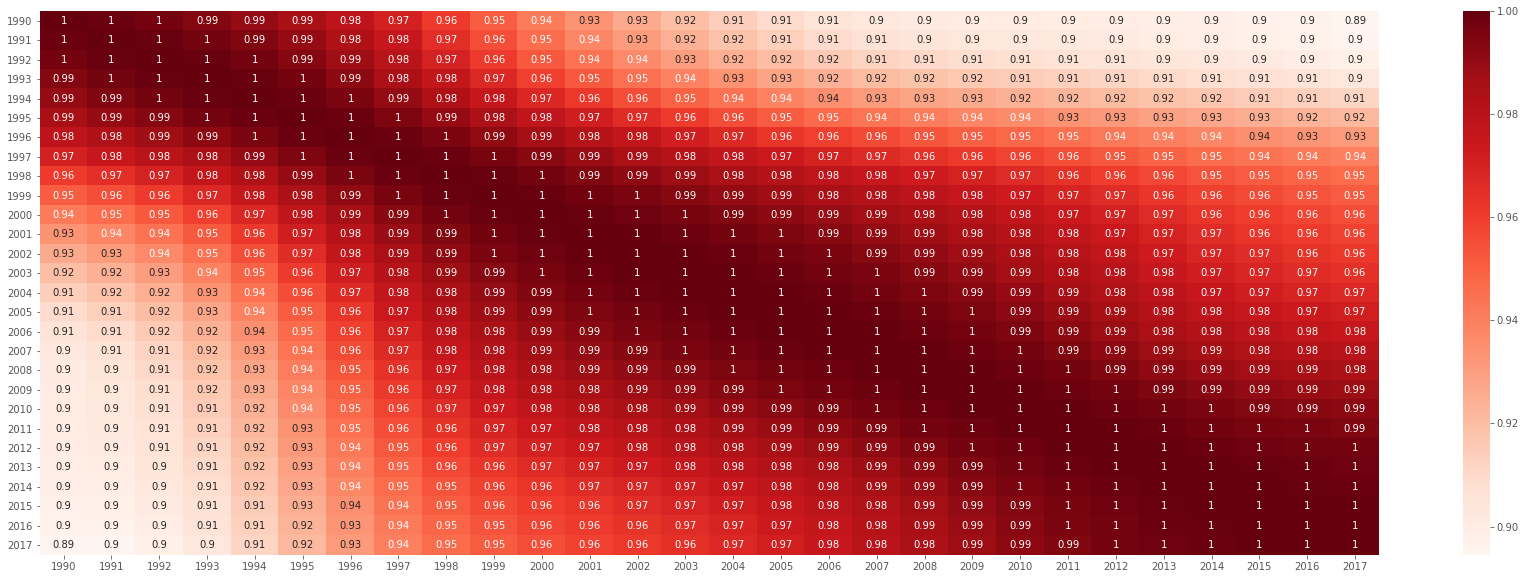

In [ ]:
plt.figure(figsize=(30,10))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Apartir del grafico de calor y la matriz de correlaciones, podemos afirmar que las variables con menos correlacion son 2017 y 1990 por tanto estas dos se tomaran en consideracion .


In [ ]:
nombre_columnas=list(dataframe.columns)
countries = dataframe['Country']
continents = dataframe['Continent']
nombre_columnas.pop(1)
for nombre in nombres_columnas:
  dataframe[nombre] = pd.to_numeric(dataframe[nombre],errors='coerce')


dataframe['Country'] = countries
dataframe['Continent'] = continents

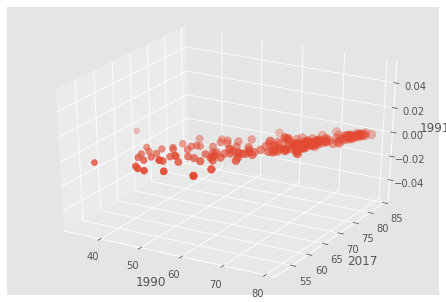

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['1991'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("1991")




plt.show()

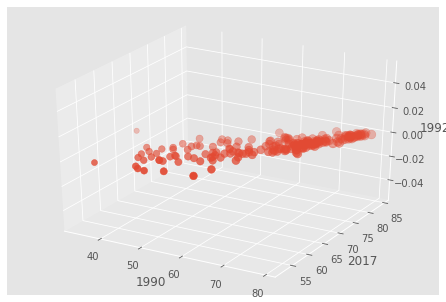

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['1992'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("1992")

plt.show()

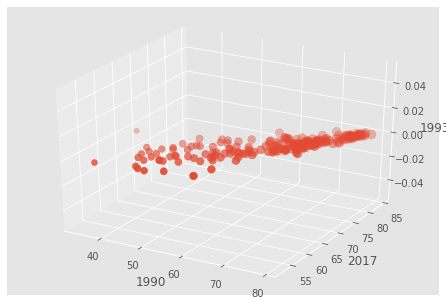

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['1993'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("1993")

plt.show()

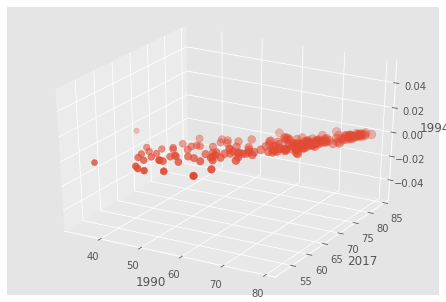

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['1994'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("1994")

plt.show()

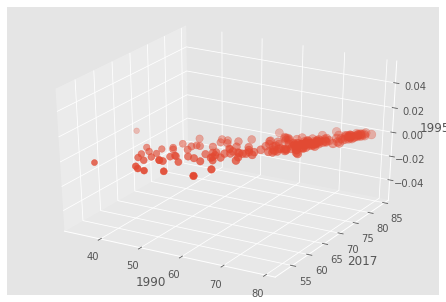

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['1995'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("1995")

plt.show()

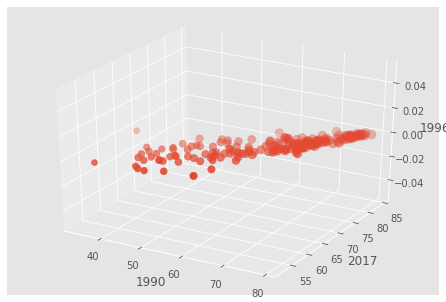

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['1996'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("1996")

plt.show()

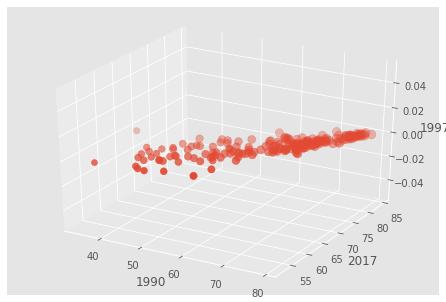

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['1997'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("1997")

plt.show()

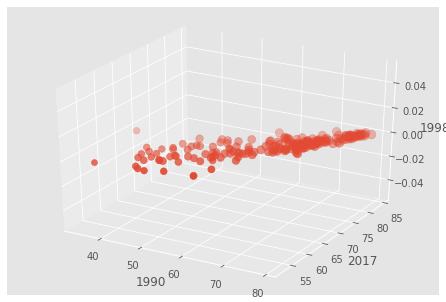

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['1998'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("1998")

plt.show()

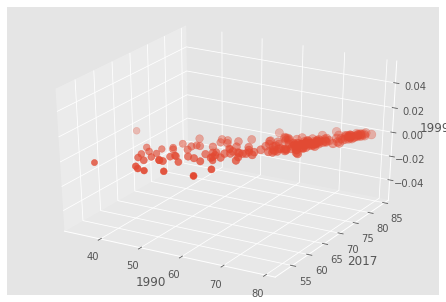

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['1999'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("1999")

plt.show()

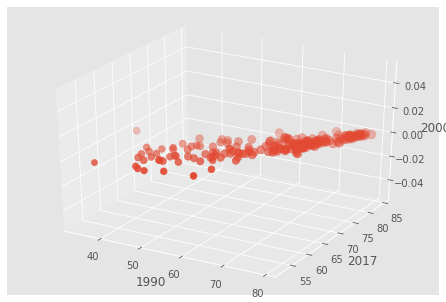

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2000'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2000")

plt.show()

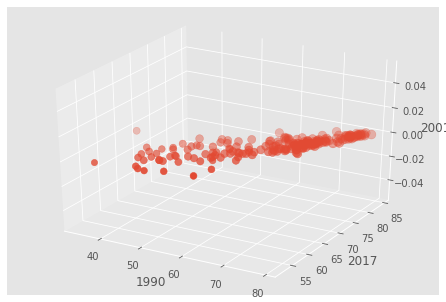

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2001'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2001")

plt.show()

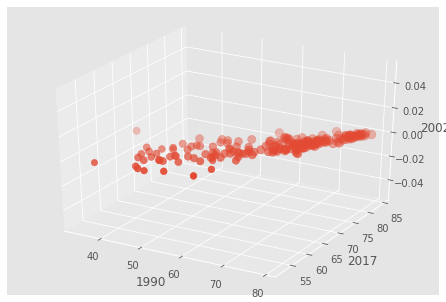

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2002'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2002")

plt.show()

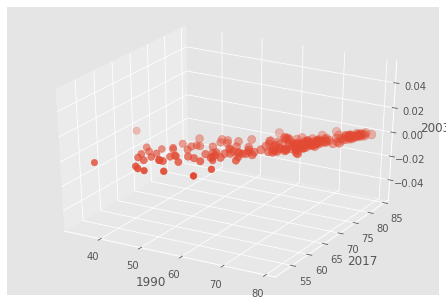

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2003'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2003")

plt.show()

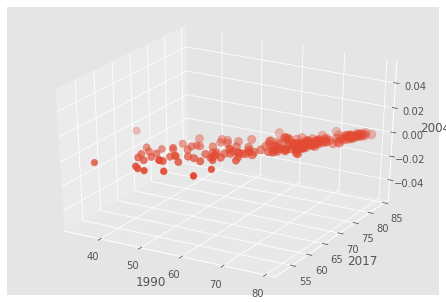

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2004'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2004")

plt.show()

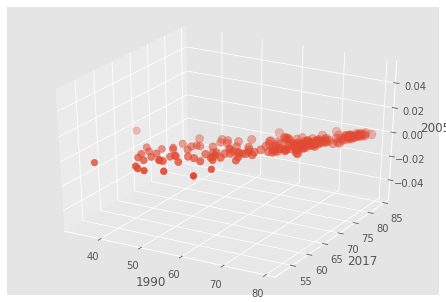

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2005'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2005")

plt.show()

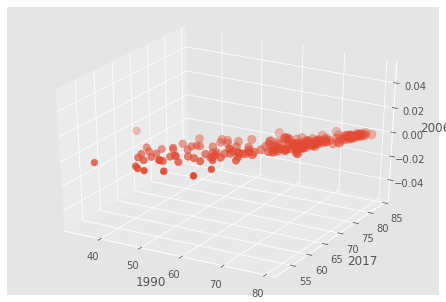

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2006'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2006")

plt.show()

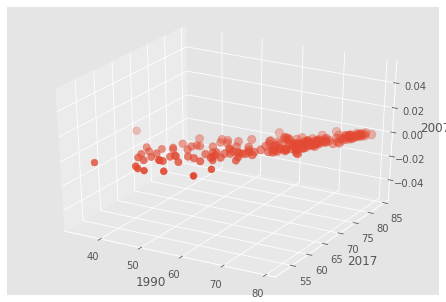

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2007'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2007")

plt.show()

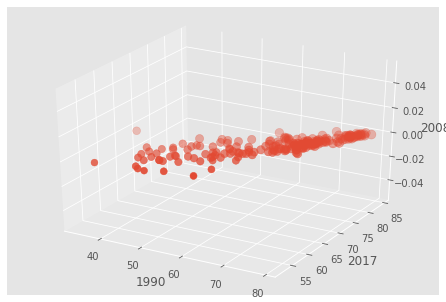

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2008'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2008")

plt.show()

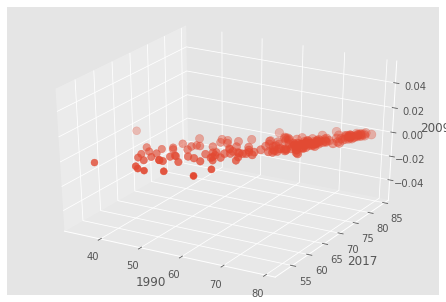

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2009'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2009")

plt.show()

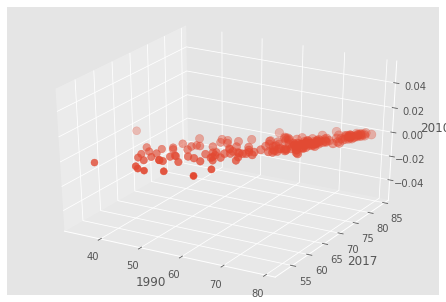

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2010'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2010")

plt.show()

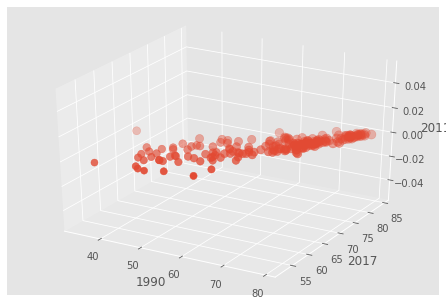

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2011'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2011")

plt.show()

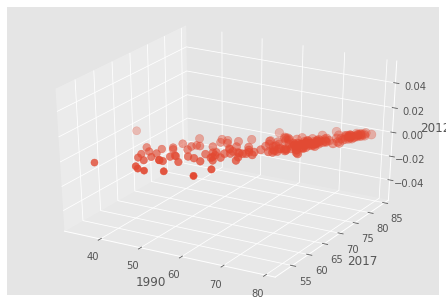

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2012'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2012")

plt.show()

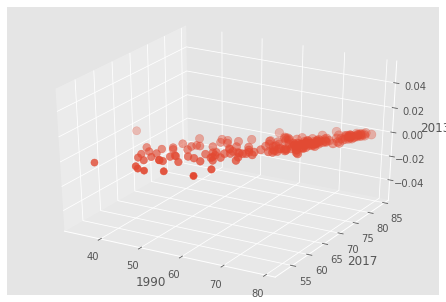

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2013'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2013")

plt.show()

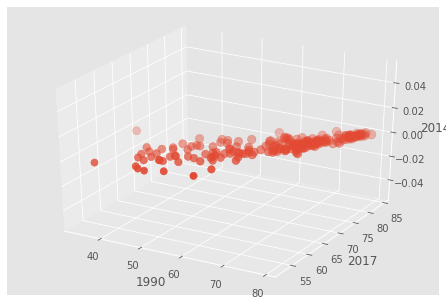

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2014'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2014")

plt.show()

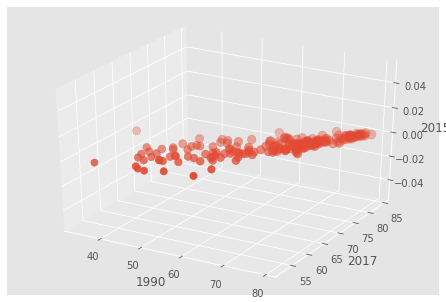

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2015'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2015")

plt.show()

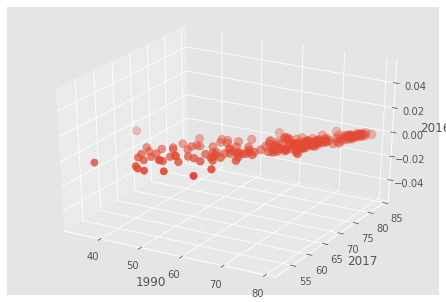

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

plt.scatter(dataframe['1990'], dataframe['2017'], dataframe['2016'])

plt.xlabel('1990')
plt.ylabel('2017')
ax.set_zlabel("2016")

plt.show()

Luego de graficar todas las variables faltantes (1990-2016) contra el 2017 y 1990 (variables preseleccionadas), y visto lo visto en las correlaciones entre los *features*, se podra escoger otra variable de manera que represente a las variables faltantes. Por lo tanto se decidio que la tercera variable con la cual se trabajara es 2003.

No se tomara la variable HDI Rank ya que es una variable categorica, y el estudio de esta por medio del clustering no es muy recomendado.

Para que exista una mayor aleatoriedad en la eleccion de los datos, se procede entonces a "revolver" todas sus filas, y ya que estas no tienen ningun orden especifico, esto no afectara de ninguna manera los datos ni el dataset.

In [ ]:
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

# Hallar el numero K de clusters

# Metodo de curva de codo
Para obtener el valor de k o número de cluster se usa una curva de codo, la cual grafica la distancia de los puntos al centroide de su cluster contra la cantidad de clusters que hay, se debe elegir el "punto de codo" o lugar donde el cambio en la distancia ya no se considera significativo.

Este método funciona de la siguiente forma, se calcula la suma de errores cuadráticos dentro del clúster para diferentes valores de K y se elige la K para la cual la suma de errores cuadráticos comienza a disminuir. Esto es visible como un codo.
Ahora bien, para aplicar el método del codo y obtener el número óptimo de 
clústeres se puede realizar de la siguiente manera:

Calcular el algoritmo de agrupación para diferentes valores de K. Por ejemplo, variando K de 1 a 8 grupos.
Para cada K, calcular la suma total del cuadrado dentro del clúster.
Trazar la curva de la suma de errores cuadráticos de acuerdo con el número de grupos K.



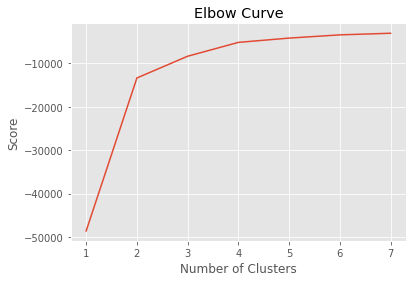

In [ ]:
# Import ElbowVisualizer

Nuevo_data = np.array(dataframe[["1990","2003","2017"]])
Nuevo_data.shape
  
Nc = range(1, 8)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(Nuevo_data).score(Nuevo_data) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


En este caso el resultado optimo seria con el numero de clusters igual a 3, a partir de este punto el numero de mejora por incremento de cluster es minimo, y por lo tanto no vale la pena aceptar un numero de cluster mayor.


# Método de la Silueta

El método de la silueta puede utilizarse para estudiar la distancia de separación entre los grupos resultantes. El gráfico de silueta muestra una medida de cuán cerca está cada punto en un clúster de los puntos en los clústeres vecinos y por lo tanto proporciona una forma de evaluar parámetros como el número de clústeres visualmente.

El coeficiente de silueta se calcula utilizando la distancia media intraclúster “a” y la distancia media más cercana al clúster “b” para cada muestra. El coeficiente de silueta para una muestra es (b – a) / max (a,b).

Este método es similar al método del codo y se puede calcular de la siguiente manera:

Calcular el algoritmo de agrupación para diferentes valores de K. Por ejemplo, variando K de 2 a 30 grupos, para este caso no se puede colocar 1 ya que no puede haber un solo clúster. Para cada K, calcular la silueta promedio de las observaciones. Trazar la curva con la silueta promedio de acuerdo con el número de clústeres K.

Los coeficientes de silueta cercanos a +1 indican que la observación se encuentra lejos de los clústers vecinos. Un valor del coeficiente de 0 indica que la observación está muy cerca o en la frontera de decisión entre dos clústers. Valores negativos indican que esas muestras quizás estén asignadas al clúster erróneo.

El método de la silueta calcula la media de los coeficientes de silueta de todas las observaciones para diferentes valores de k. El número óptimo de clústers k es aquel que maximiza la media de los coeficientes de silueta para un rango de valores de k.



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f110d860390>,
                 k=None, metric=None, model=None, timings=True)

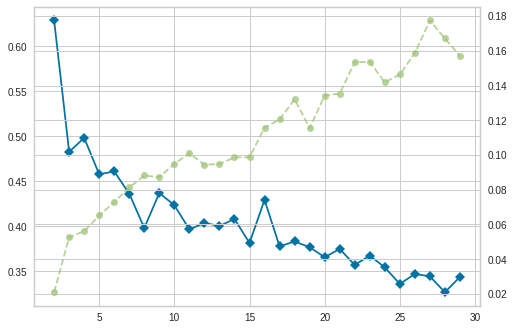

In [ ]:

from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# Siendo k el numero de clusters
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(Nuevo_data)        

En este caso el metodo de clusters optimos es 2, en el cual la grafica alcanza su maximo local, y a partir de este punto los coeficientes empiezan a descender levemente, indicando que los clusters empiezan a representar los mismos conjuntos y por lo tanto no hay divisiones claras. 


Gracias a estos dos analisis decidimos usar 3 como numero de clusters, ya que en el grafico de la curva de codo nos dio este como el numero optimo y en el metodo de la silueta, aunque el resultado que arroja es 2, este numero es muy pequeño para representar una base de datos tan grande, tambien se puede observar que la diferencia entre 3 y 4 en el metodo de la silueta es de menos de 0.03 y por lo tanto no representa una diferencia significativa el usar a 3 como el numero de clusters, ademas de que nos perimte analizar y segmentar de mejor manera los conjuntos de datos.



## K MEANS ANALISIS 

A continuacion se mira como se agrupan los datos apartir de las tres variables mencionadas, se utilizaran 3 variables de naturaleza continua, especiadas por el mismo periodo de tiempo aproximadamente (1990,2003,2017), para una mejor distribucion de los datos:



In [ ]:
Dataframe_3D = dataframe[['1990', '2003','2017']]
Dataframe3V = dataframe[['HDI Rank (2017)', 'Country', '1990', '2003','2017', 'Continent', 'PIB']]
Dataframe_3D = np.array(Dataframe_3D)

kmeans_model_3D = KMeans(n_clusters=3, max_iter=1000).fit(Dataframe_3D)

Ahora se visualizaran las etiquetas dadas por el modelo y los centroides:

In [ ]:
centroids_3D = kmeans_model_3D.cluster_centers_
centroids_3D
##kmeans_model_3D.labels_

array([[66.265     , 69.515     , 72.85125   ],
       [51.38867925, 53.62830189, 62.07735849],
       [74.43965517, 77.34482759, 80.05517241]])

Vamos a visualizar las categorias y los centroides encontrados, todo en un solo gráfico de dispersión, usando colores para cada categoria.

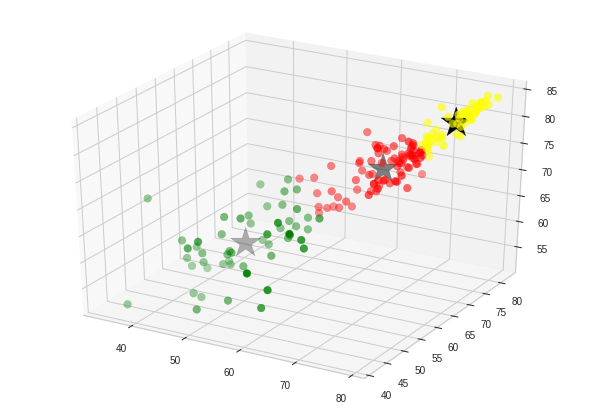

In [ ]:
# Predicting the clusters
labels = kmeans_model_3D.predict(Dataframe_3D)
# Getting the cluster centers
C = kmeans_model_3D.cluster_centers_
colores=['red','green','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Dataframe_3D[:, 0], Dataframe_3D[:, 1], Dataframe_3D[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1],C[:, 2] , marker='*', c="black", s=1000)

Separamos el dataframe por su cluster, para permitirnos interpretar los resultados

In [ ]:
Dataframe3V['Type'] = kmeans_model_3D.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:

Dataframe3VTipo0 = Dataframe3V[Dataframe3V['Type'] == 0]
Dataframe3VTipo1 = Dataframe3V[Dataframe3V['Type'] == 1]
Dataframe3VTipo2 = Dataframe3V[Dataframe3V['Type'] == 2]

## CARACTERISTICAS REPRESENTATIVAS

Para cada grupo se haran una serie de analisis para establecer que caracteristicas son representativas.

Se comenzara por la medidas de tendencia central:


*   Se sacara un promedio de cada fila (pais)




In [ ]:
Dataframe3VTipo0['mean'] = Dataframe3VTipo0.iloc[:, 2:4].mean(axis=1)
Dataframe3VTipo1['mean'] = Dataframe3VTipo1.iloc[:, 2:4].mean(axis=1)
Dataframe3VTipo2['mean'] = Dataframe3VTipo2.iloc[:, 2:4].mean(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Apartir de la columna mean se cada tipo de datos se obtendra lo siguiente:

## Analsis de los grupos

In [ ]:
Dataframe3VTipo0.agg(
       {
            "mean": ["min", "max", "median", "skew","mean"],
            
        }
    )

,mean
min,59.350000
max,72.300000
median,68.450000
skew,-0.817482
mean,67.890000


In [ ]:
Dataframe3VTipo1.agg(
       {
            "mean": ["min", "max", "median", "skew","mean"],
            
        }
    )

,mean
min,39.500000
max,60.250000
median,52.600000
skew,-0.384350
mean,52.508491


In [ ]:
Dataframe3VTipo2.agg(
       {
            "mean": ["min", "max", "median", "skew","mean"],
            
        }
    )

,mean
min,72.200000
max,80.450000
median,76.250000
skew,-0.092631
mean,75.892241


## NOTA IMPORTANTE

Aunque en la columna type se llaman los clusters (0,1,2), habiendo identificado su caracteristica representativa y diferenciadora (expectativa de vida) se referira a ellos como grupo bajo, promedio y alto, el el posterior parrafo se hablara puntualmente de cada uno de ellos.

Sabiendo que el grupo bajo para nuestro analisis es es aquel que presento un promedio menor de expectativa de vida y que el grupo promedio sera aquel que registro un intermedio de expectativa y el grupo alto los paises con un promedio de expectativa de vida mas alta  en los años 1990,2003,2017:
Con los resultados anteriores poder concluir que:
*   Al menos el 50% de los paises en el  grupo bajo, en los años 1990,2003 y 2017 tienen una expectativa de vida que esta alrededor de 52.66 años.
* Al menos el 50% de los paises en el grupo promedio, en los años 1990,2003 y 2017 tienen una expectativa de vida que esta alrededor de 68.03 años.
* Al menos el 50% de los paises en el grupo alto, en los años 1990,2003 y 2017 tienen una expectativa de vida que esta alrededor de 75.94 años.
* Al observar la mediana y la media, se observa que hay poca presencia de datos atipicos en los grupos.
* El grupo bajo, aunque tiene poco sesgo, este es negativo, esto quiere decir que hay varios datos concetrados en la cola izquierda de la distribucion, es decir hay varios datos menores que la media.
*  El grupo promedio, aunque tiene poco sesgo, este es negativo, esto quiere decir que hay varios datos concetrados en la cola izquierda de la distribucion, es decir hay varios datos menores que la media.
*  El grupo alto, aunque tiene poco sesgo, este es negativo, esto quiere decir que hay varios datos concetrados en la cola izquierda de la distribucion, es decir hay varios datos menores que la media.

El grupo alto tiene una distribucion mas simetrica que el grupo bajo y el grupo promedio.





Es importante analizar los datos como un conjunto, para esto se generara un boxplot 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


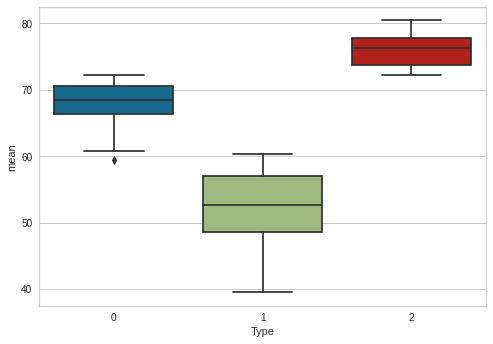

In [ ]:
Dataframe3V['mean'] = Dataframe3V.iloc[:, 2:4].mean(axis=1)
ax = sns.boxplot(x="Type", y="mean", data=Dataframe3V)

Se evidencia que en los grupos bajo y alto no hay datos atipicos, ni atipicos extremos  en ninguno de los grupos. Mientras que el grupo promedio presenta un solo dato atipico, no extremo.

Ademas el grafico es evidencia de que la expectativa de vida promedio de los años 1990, 2003 y 2017 de un grupo es superior a la del otro.

Gracias al grafico *boxplot* podemos entonces evidencia como el percentil 75 del grupo con menor expectativa de vida (menor) esta por debajo del percentil 25 de el grupo con expectativa media de vida (promedio), esto demuestra que por lo menos el 75% de la expectativa de vida de los años 1990, 2003, 2017 del grupo menor es inferior a almenos el 75% de la expectativa de vida de los años 1990, 2003, 2017 del grupo promedio.

Gracias al grafico *boxplot* podemos entonces evidencia como el percentil 75 del grupo con  expectativa de vida media (medio) esta por debajo del percentil 25 de el grupo con expectativa alta de vida (alta), esto demuestra que por lo menos el 75% de la expectativa de vida de los años 1990, 2003, 2017 del grupo medio es inferior a almenos el 75% de la expectativa de vida de los años 1990, 2003, 2017 del alto.





## Conclusiones de centroides

In [ ]:


representantes,_ = pairwise_distances_argmin_min(centroids_3D,dataframe[['1990', '2003','2017']] )
print(representantes)

[134  46 123]


In [ ]:
print(dataframe[['Country','1990', '2003','2017']].iloc[[35]])

     Country  1990  2003  2017
35  Paraguay  68.0  70.8  73.2


In [ ]:
print(dataframe[['Country','1990', '2003','2017']].iloc[[58]])

   Country  1990  2003  2017
58  Greece  76.6  79.2  81.4


In [ ]:
print(dataframe[['Country','1990', '2003','2017']].iloc[[114]])

    Country  1990  2003  2017
114   Egypt  64.6  69.1  71.7


Los centroides  para cada cluster son : para el cluster con mas baja expectativa de vida se tiene a Guinea como representante, despues se tiene a Honduras como principal actor de el cluster con expectativa de vida promedio, y por ultimo se tiene a Cuba como el centroide del grupo con mayor esperanza de vida.


# Conclusiones colombia


In [ ]:
Dataframe3VTipo0.loc[Dataframe3VTipo0['Country'] == 'Colombia']

,HDI Rank (2017),Country,1990,2003,2017,Continent,PIB,Type,mean
97,90,Colombia,68.3,71.8,74.6,South America,323615.0,0,70.05


Al consultar sobre los resultados de Colombia notamos que se encuentra en el  grupo con expectativa de vida promedio.
Luego de encontrar los paises mas cercanos a los centroides de cada grupo, podemos evidenciar que Colombia esta mas cerca de Honduras en cuanto se refiere a expectativa de vida que a los otros dos candidatos.

De igual manera, se sabe que Colombia hace parte de las americas, pero lastimosamente, como la mayoria de paises, Colombia hace parte del grupo promedio, por encima de Colombia, hay paises como Chile, Argentina, Canada y Estados unidos, los cuales poseen una mayor expectativa de vida en comparacion, y por debajo de Colombia podemos ver paises como Bolivia, Surinam y Guyana.

Por el lado del PIB colombia cuenta con 323.615 millones de dolares de producto interno bruto, lo cual representa un PIB menor que el promedio global(446.876) pero que no es tan malo si se compara con los paises vecinos, estando por encima de paises como Chile,Ecuador,Peru y las guayanas , pero por debajo de paises como Argentina, Brazil o Venezuela.

## Clasificamos los clusters por continentes

In [ ]:
print('Asia:')
print(Dataframe3VTipo0[Dataframe3VTipo0.Continent == 'Asia'].shape[0])
print('Europe:')
print(Dataframe3VTipo0[Dataframe3VTipo0.Continent == 'Europe'].shape[0])
print('Oceania:')
print(Dataframe3VTipo0[Dataframe3VTipo0.Continent == 'Oceania'].shape[0])
print('South America:')
print(Dataframe3VTipo0[Dataframe3VTipo0.Continent == 'South America'].shape[0])
print('North America:')
print(Dataframe3VTipo0[Dataframe3VTipo0.Continent == 'North America'].shape[0])
print('Africa:')
print(Dataframe3VTipo0[Dataframe3VTipo0.Continent == 'Africa'].shape[0])

Asia:
30
Europe:
11
Oceania:
10
South America:
8
North America:
12
Africa:
9


In [ ]:
print('Asia:')
print(Dataframe3VTipo1[Dataframe3VTipo1.Continent == 'Asia'].shape[0])
print('Europe:')
print(Dataframe3VTipo1[Dataframe3VTipo1.Continent == 'Europe'].shape[0])
print('Oceania:')
print(Dataframe3VTipo1[Dataframe3VTipo1.Continent == 'Oceania'].shape[0])
print('South America:')
print(Dataframe3VTipo1[Dataframe3VTipo1.Continent == 'South America'].shape[0])
print('North America:')
print(Dataframe3VTipo1[Dataframe3VTipo1.Continent == 'North America'].shape[0])
print('Africa:')
print(Dataframe3VTipo1[Dataframe3VTipo1.Continent == 'Africa'].shape[0])

Asia:
6
Europe:
0
Oceania:
0
South America:
1
North America:
1
Africa:
44


In [ ]:
print('Asia:')
print(Dataframe3VTipo2[Dataframe3VTipo2.Continent == 'Asia'].shape[0])
print('Europe:')
print(Dataframe3VTipo2[Dataframe3VTipo2.Continent == 'Europe'].shape[0])
print('Oceania:')
print(Dataframe3VTipo2[Dataframe3VTipo2.Continent == 'Oceania'].shape[0])
print('South America:')
print(Dataframe3VTipo2[Dataframe3VTipo2.Continent == 'South America'].shape[0])
print('North America:')
print(Dataframe3VTipo2[Dataframe3VTipo2.Continent == 'North America'].shape[0])
print('Africa:')
print(Dataframe3VTipo2[Dataframe3VTipo2.Continent == 'Africa'].shape[0])

Asia:
13
Europe:
30
Oceania:
2
South America:
3
North America:
10
Africa:
0


Con los anteriores resultados, podemos ver la reparticion de los paises segun su continente, esto permite evidenciar que:

* Los paises asiaticos, a pesar de estar repartidos entre los 3 clusters, podemos ver facilmente como la mayoria de los paises asiatico se encuentran con una esperanza de vida que promedio, aunque a pesar de esto tiene paises como Japon y Hong Kong, los cuales superan estos promedios, tambien exhibe paises como Afganistan y Temor-Lester que poseen esperanzas de vida mucho mas bajas.

* Los paises europeos, se encuentran en el grupo donde la esperanza de vida es la mas alta, o la promedio, aqui se puede evidenciar que este continente por ende posee una expectativa general muy alta.

* Los paises oceanicos, tienen un acercamiento mas al promedio de la expectativa de vida, a excepcion de 3 paises, Nueva Zelanda y Australia con una expectativa mayor y Papua New Guinea con una expectativa menor.

* Los paises de las americas, posee una mayoria de paises con expectativas de vida promedios, exceptuando casos como lo son Bolivia, y Estados Unidos, paises que se alejan de este promedio por debajo y por encima respectivamente. Claro esta tambien que las americas tiene una inclinacion a tener unas expectativas mayores que las promedio.

* Y los paises africanos, lastimosamente, tienen una gran mayoria de paises presentes en el grupo donde la expectativa de vida es baja, solo a excepcion de 9 paises, entre ellos Egipto, Tunez y Algeria, que se situan en el grupo mas abundante de paises, donde la expecativa de vida es promedio



## Clasificamos los clusters por PIB

Para identificar si existe alguna relacion entre la economia de un pais y su expectativa de vida, realizamos un histograma por cluster.

# Histograma de PIB para primer cluster

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f110bd1f510>]],
      dtype=object)

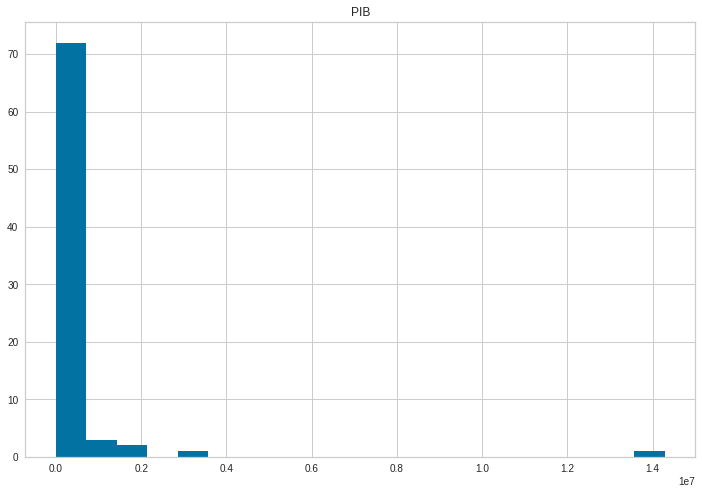

In [ ]:
Dataframe3VTipo0.hist(column='PIB',figsize=(12,8),bins=20)

## Histograma de PIB para el segundo cluster con rango de valores enfocado entre 0 y 10.000.000 millones de dolares


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f110a629dd0>]],
      dtype=object)

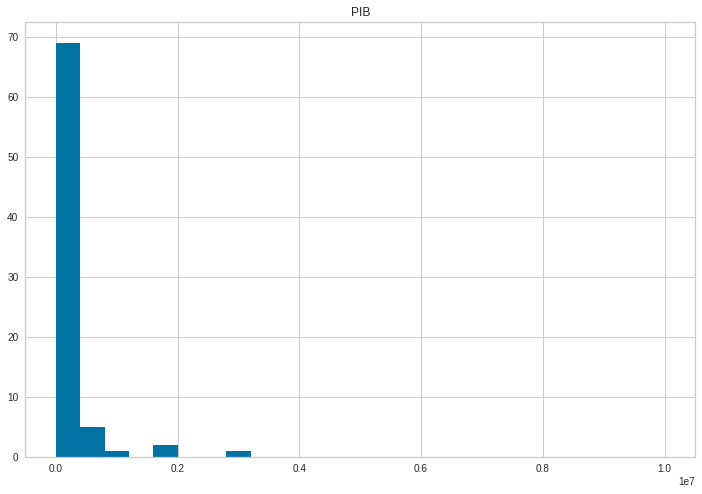

In [ ]:
Dataframe3VTipo0.hist(column='PIB',figsize=(12,8),bins=25,range=(0, 10000000))

# Histograma de PIB para el segundo cluster


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f110bb98a90>]],
      dtype=object)

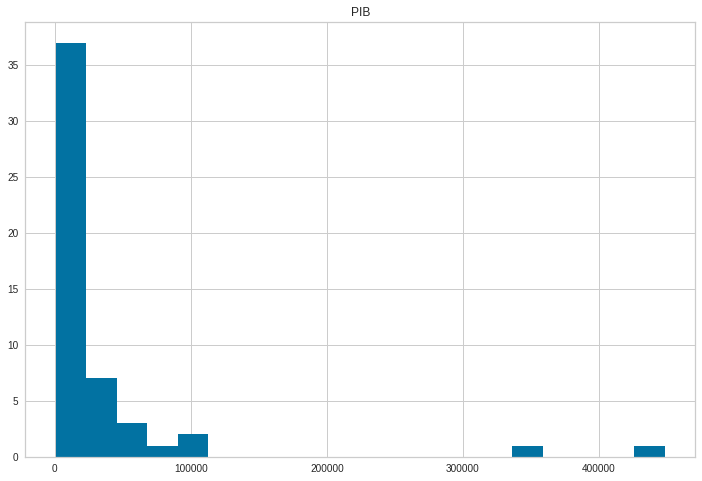

In [ ]:
Dataframe3VTipo1.hist(column='PIB',figsize=(12,8),bins=20)

## Histograma de PIB para el segundo cluster con rango de valores enfocado entre 0 y 10.000.000 millones de dolares

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f110b915610>]],
      dtype=object)

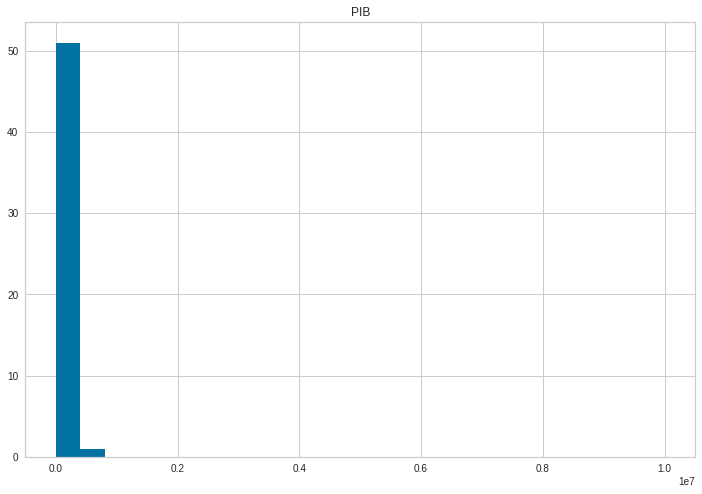

In [ ]:
Dataframe3VTipo1.hist(column='PIB',figsize=(12,8),bins=25,range=(0, 10000000))

# Histograma de PIB para el tercer cluster

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f110bb05b50>]],
      dtype=object)

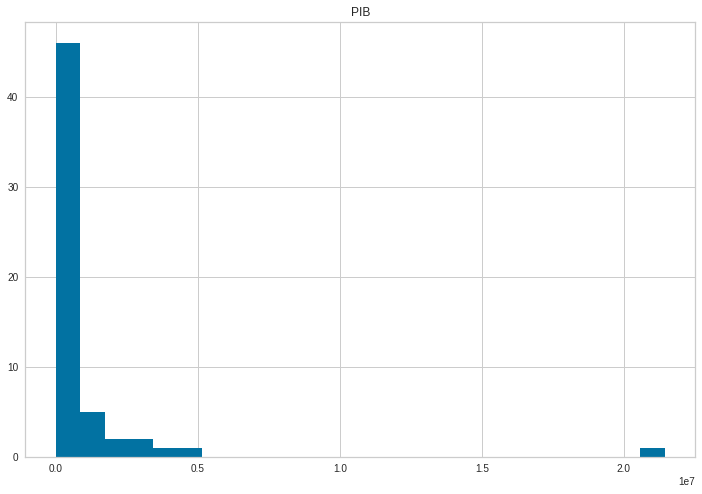

In [ ]:
Dataframe3VTipo2.hist(column='PIB',figsize=(12,8),bins=25)

## Histograma de PIB para el tercer cluster con rango de valores enfocado entre 0 y 10.000.000 millones de dolares

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f110dcbc0d0>]],
      dtype=object)

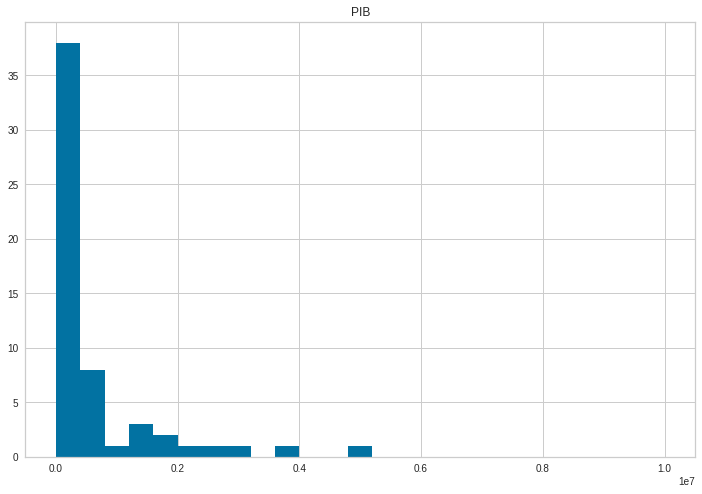

In [ ]:
Dataframe3VTipo2.hist(column='PIB',figsize=(12,8),bins=25,range=(0, 10000000))

Gracias a los histogramas,que nos muestran la distribucion de PIB(producto interno bruto) en millones de dolares, de los paises en los distintos clusters podemos identificar los comportamientos y correlaciones de estos con el grupo en el que quedaron, Si tomamos al cluster con menor expectativa de vida como el tipo "A", el de expectativa promedio como "B", y el mayor como "C", cuya esperanza de vida es la mayor de todas, podemos establecer algunas conclusiones:

Para el tipo A cuya esperanza de vida es la menor a todas, es posible identificar que cuenta con los Indices de PIB mas bajos, Encontrandose la gran mayoria de paises de este grupo entre 0 y 20,000 millones de dolares de PIB, algunos otros se encuentran dentro del conjunto de los 20,000-60,000 millones de dolares de PIB, sin embargo son contados estos casos. Son incluso mas pocos los casos mayores a 100,000 teniendo apenas un par cerca de los 400,000.

Sin embargo para los clusters de tipo B y C que cuentan con una esperanza de vida mas larga que el cluster tipo A, vemos que tambien aumenta su PIB; en estos casos podemos observar que casi todos los valores de tipo B se encuentran entre 0 y 1,000,000 millones de dolares de PIB, con algunos datos que presentan PIB mas elevados entre 1,000,000 y 5,000,000 , y un dato muy elevado con 14.000.000 que representa a china. Mientras de que el tipo C la gran mayoría de valores se concentra entre 0 y 5,000,000 de millones de dólares y un dato lejano de 20 billones que representa estados unidos

Con los datos anteriores podemos concluir que la economia de un pais y en este caso especifico,el PIB, tiene correlacion directa con la expectativa de vida de sus ciudadanos,lo cual probablemente involucre una causalidad, ya que en los paises con mejor economia, las personas pueden adquirir con mayor facilidad productos para cuidar su bienestar, y adquirir mejores soluciones a problemas criticos de la salud. Ademas de que las personas que viven en paises con economia mas estable, tienden a vivir de una manera mas amena, lo que indica menos amenazas para su vida, y que mientras peor economia tenga una region mas dificil va a ser para sus habitantes alcanzar una edad avanzada.